In [53]:
import os
import pcse
import yaml
import pandas as pd
import datetime as dt
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from pcse.models import Wofost71_PP, Wofost71_WLP_FD
from pcse.base import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse import fileinput as fi
from pcse.util import WOFOST71SiteDataProvider

In [42]:
agro_yaml = """
Version: 1.0
AgroManagement:
- {sim_start_date}:
    CropCalendar:
        crop_name: maize
        variety_name: Maize_VanHeemst_1988
        crop_start_type: sowing
        crop_start_date: {crop_start_date}
        crop_end_type: earliest
        crop_end_date: {crop_end_date}
        max_duration: 300
    TimedEvents: 
    -   event_signal: apply_n
        name:  Nitrogen application table
        comment: All nitrogen amounts in g N m-2
        events_table:
        - {fert_date}: {{amount: {n_rate}, recovery: 0.7}}
    StateEvents: null
"""

In [43]:
soilfile = '../data/soils/MX03737840.sol'
soildata = fi.CABOFileReader(soilfile)
soildata.update({'RDMSOL': 200, 'SM0': 0.4, 'SMW': 0.1})

cropdata = fi.YAMLCropDataProvider()
cropdata.set_active_crop('maize', 'Maize_VanHeemst_1988')

sitedata = WOFOST71SiteDataProvider(WAV=100, CO2=360)

parameters = ParameterProvider(cropdata=cropdata, soildata=soildata, sitedata=sitedata)


In [44]:
wdp = NASAPowerWeatherDataProvider(latitude=16.239, longitude=-92.954)

In [45]:
print(wdp)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER SRB/FLASHFlux/MERRA2/GEOS 5.12.4 (FP-IT) 0.5 x 0.5 Degree Daily Averaged Data
----Site characteristics----
Elevation:  986.4
Latitude:  16.239
Longitude: -92.954
Data available for 1983-07-01 - 2020-02-25
Number of missing days: 30



In [54]:
sdate = dt.date(2000,1,1)

results = []
for doy in trange(120,240,7):
    # get new start date
    sim_start_date = sdate + dt.timedelta(days = doy - 90)
    crop_start_date = sdate + dt.timedelta(days = doy)
    crop_end_date = sdate + dt.timedelta(days = doy + 210)
    fert_date = sdate + dt.timedelta(days = doy + 30)
    n_rate = 12
    
    # update agromanagement with new start date and load it with yaml.load
    tmp = agro_yaml.format(sim_start_date = sim_start_date,
                           crop_start_date = crop_start_date,
                           crop_end_date = crop_end_date,
                           fert_date = fert_date,
                           n_rate = n_rate)
    agromanagement = yaml.load(tmp, yaml.FullLoader)
    
    wofsim = Wofost71_WLP_FD(parameters, wdp, agromanagement)
    wofsim.run_till_terminate()
    output = wofsim.get_output()
    df = pd.DataFrame(output).set_index("day")
    results.append(df)
    
    summary_output = wofsim.get_summary_output()
    msg = "Reached maturity at {DOM} with total biomass {TAGP:0.2f} kg/ha and a yield of {TWSO:0.2f} kg/ha."
    print(msg.format(**summary_output[0]))


Reached maturity at 2000-08-27 with total biomass 21861.02 kg/ha and a yield of 10532.28 kg/ha.
Reached maturity at 2000-09-05 with total biomass 22811.58 kg/ha and a yield of 10426.45 kg/ha.
Reached maturity at 2000-09-12 with total biomass 22914.46 kg/ha and a yield of 10743.80 kg/ha.
Reached maturity at 2000-09-20 with total biomass 22912.53 kg/ha and a yield of 10920.22 kg/ha.
Reached maturity at 2000-09-27 with total biomass 23005.64 kg/ha and a yield of 10743.19 kg/ha.
Reached maturity at 2000-10-05 with total biomass 22841.50 kg/ha and a yield of 10451.44 kg/ha.
Reached maturity at 2000-10-12 with total biomass 22694.29 kg/ha and a yield of 9972.21 kg/ha.
Reached maturity at 2000-10-19 with total biomass 22790.88 kg/ha and a yield of 9671.76 kg/ha.
Reached maturity at 2000-10-27 with total biomass 22644.79 kg/ha and a yield of 9494.46 kg/ha.
Reached maturity at 2000-11-04 with total biomass 21740.87 kg/ha and a yield of 9316.19 kg/ha.
Reached maturity at 2000-11-11 with total bi

In [56]:
summary_output

[{'DVS': 2.0,
  'LAIMAX': 7.536280068409327,
  'TAGP': 9112.56287912766,
  'TWSO': 705.2223478495022,
  'TWLV': 3812.149409708084,
  'TWST': 4595.191121570075,
  'TWRT': 1692.645813246787,
  'CTRAT': 13.232796970812695,
  'RD': 75.0,
  'DOS': datetime.date(2000, 8, 27),
  'DOE': datetime.date(2000, 9, 2),
  'DOA': datetime.date(2000, 10, 29),
  'DOM': datetime.date(2001, 1, 8),
  'DOH': None,
  'DOV': None}]

In [55]:
pd.concat(results)

DVS       LAI         TAGP        TWSO        TWLV  \
day                                                                   
2000-01-31       NaN       NaN          NaN         NaN         NaN   
2000-02-01       NaN       NaN          NaN         NaN         NaN   
2000-02-02       NaN       NaN          NaN         NaN         NaN   
2000-02-03       NaN       NaN          NaN         NaN         NaN   
2000-02-04       NaN       NaN          NaN         NaN         NaN   
...              ...       ...          ...         ...         ...   
2001-01-04  1.959837  0.998943  9112.562879  705.222348  3812.14941   
2001-01-05  1.972340  0.967098  9112.562879  705.222348  3812.14941   
2001-01-06  1.984843  0.936208  9112.562879  705.222348  3812.14941   
2001-01-07  1.998335  0.906244  9112.562879  705.222348  3812.14941   
2001-01-08  2.000000  0.877180  9112.562879  705.222348  3812.14941   

                   TWST         TWRT  TRA    RD        SM      WWLOW  
day                                                                   
2000-01-31          NaN          NaN  NaN   NaN  0.400000  80.000000  
2000-02-01          NaN          NaN  NaN   NaN  0.148000  55.806016  
2000-02-02          NaN          NaN  NaN   NaN  0.137622  31.672234  
2000-02-03          NaN          NaN  NaN   NaN  0.128641  29.406414  
2000-02-04          NaN          NaN  NaN   NaN  0.117565  29.295653  
...                 ...          ...  ...   ...       ...        ...  
2001-01-04  4595.191122  1692.645813  0.0  75.0  0.097449  25.808699  
2001-01-05  4595.191122  1692.645813  0.0  75.0  0.096874  25.765578  
2001-01-06  4595.191122  1692.645813  0.0  75.0  0.096615  25.746091  
2001-01-07  4595.191122  1692.645813  0.0  75.0  0.096468  25.735108  
2001-01-08  4595.191122  1692.645813  0.0  75.0  0.096434  25.732547  

[3895 rows x 11 columns]

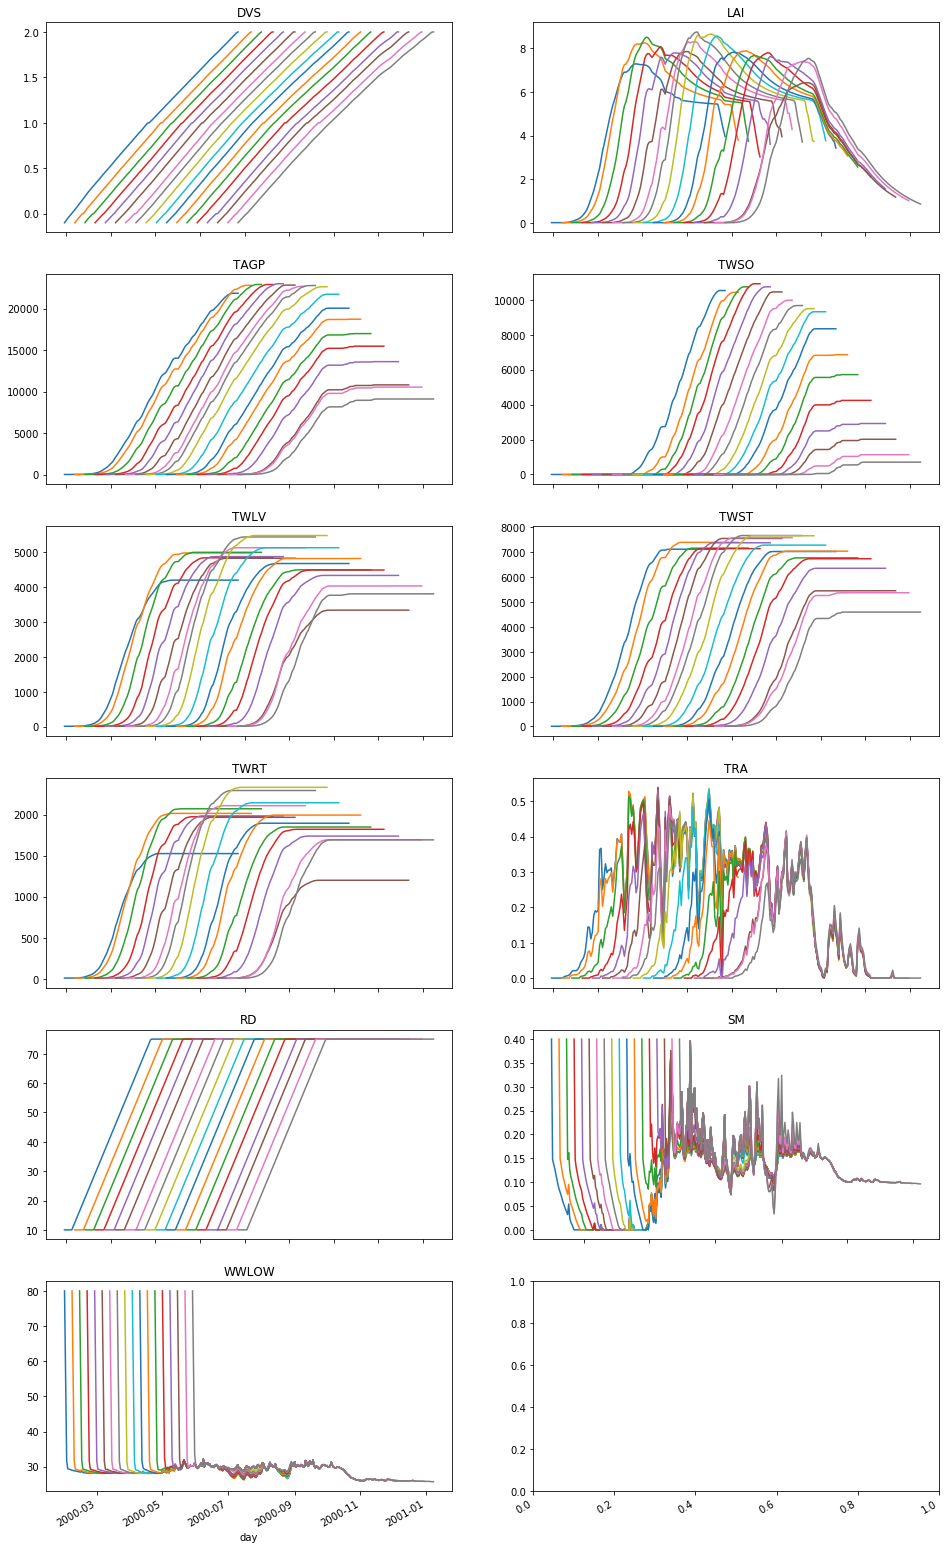

In [52]:
fig5, axes5 = plt.subplots(nrows=6, ncols=2, figsize=(16,30))
for df in results:
    for key, axis in zip(df.columns, axes5.flatten()):
        df[key].plot(ax=axis, title=key)
fig5.autofmt_xdate()
